# Two Stage Prediction 

# Two-Stage Prediction Notebook

## Overview
This Jupyter Notebook implements a two-stage prediction model, designed to enhance the accuracy of load consumption forecasting. The first stage involves modeling predictions based on yearly aggregated features, including GDP, population, and energy structure, capturing broader economic and structural influences. The second stage refines this prediction by incorporating daily-level data to provide a more granular forecast of load consumption.

By leveraging historical data, carefully engineered features, and advanced predictive techniques, this notebook aims to improve the precision of short-term energy demand forecasting, offering valuable insights for decision-making in energy management and planning.

## Structure

### 1. Data Loading and Preprocessing
- Reads the dataset
- Feature engineering, and transformations.
- Visualizes key data distributions.

### 2. Feature Selection and Engineering
- Extracts important features from the dataset.
- Implements techniques such as normalization, encoding, or dimensionality reduction.

### 3. Model Training - First Stage
- Trains an initial predictive model (random forest).
- Evaluates its performance using metrics such as RMSE, accuracy, or R².

### 4. Model Training - Second Stage
- Utilizes the first-stage predictions as input features.
- Trains a secondary model to refine the predictions.

### 5. Model Evaluation
- Assesses the performance of both models.
- Compares results and visualizes key insights.

### 6. Predictions and Conclusions
- Generates final predictions based on the two-stage model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [2]:
# Load Data

daily_data = pd.read_csv("merged_data_granualityBased/daily_merged_data(no_lags).csv")
monthly_data = pd.read_csv("merged_data_granualityBased/merged_monthyl_data.csv")
yearly_data = pd.read_csv("merged_data_granualityBased/merged_Yearly_data.csv")


In [3]:
daily_data.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,8.0,24,4.0,1,1,2015,1,201501,Thursday
1,2015-01-02,319026.0,4.3,1.7,3,7.3,44,1,10.1,8,6.1,9.0,2,4.0,20,1,2015,1,201501,Friday
2,2015-01-03,313131.0,1.5,0.5,10,3.8,26,17,5.9,1,3.3,5.0,7,1.0,17,1,2015,1,201501,Saturday
3,2015-01-04,296832.0,-0.1,-0.1,1,3.9,-3,21,8.0,13,2.4,3.0,11,2.0,1,1,2015,1,201501,Sunday
4,2015-01-05,350937.0,0.0,0.0,1,2.4,9,11,3.8,24,3.0,5.0,11,1.0,22,1,2015,2,201502,Monday


In [4]:
# Convert datetime columns
daily_data["date"] = pd.to_datetime(daily_data["date"])

daily_data.set_index("date", inplace=True)

In [5]:
# Ensure numerical columns are correctly formatted
yearly_data["Population"] = yearly_data["Population"].str.replace(',', '').astype(float)

In [6]:
# Feature Engineering Function
def feature_importance_rfa(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.sort_values(ascending=False, inplace=True)
    
    #Print feature importances
    print("Feature Importances (Descending Order):")
    print(feature_importances)
    
    return feature_importances

## Stage 1: Yearly Forecasting

In [56]:
#yearly_data.columns

In [8]:
# One-Hot Encode PriceComponents
yearly_data = pd.get_dummies(yearly_data, columns=["PriceComponents"], drop_first=True)

In [9]:
# Ensure all rows are printed
pd.set_option('display.max_rows', None)

In [57]:
# Select Features and Target
selected_features = ['Population', 'GDP','AveragePrice_Electricity_Household', 'Totaal windenergie (MWh)', 'TotalSolarEnergy (MWh)', 'TotalRes(incl.Stat.Transfer) (MWh)']

# Define the feature matrix X and the target variable y.
X_yearly = yearly_data[selected_features]
y_yearly = yearly_data['loadConsumption'] 


In [58]:
# Split the data into training and testing sets
X_train_yearly, X_test_yearly, y_train_yearly, y_test_yearly = train_test_split(X_yearly, y_yearly, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_yearly)
X_test_scaled = scaler.transform(X_test_yearly)

In [79]:
# Train MOdel
# Train Model
model_yearly = RandomForestRegressor(n_estimators=100, max_depth= 4,random_state=42, max_features="sqrt", min_samples_split=5)
model_yearly.fit(X_train_scaled, y_train_yearly)
y_pred_yearly = model_yearly.predict(X_test_scaled)


In [80]:
# Store yearly predictions in monthly dataset
monthly_data["Predicted_Yearly_Load"] = np.repeat(
    model_yearly.predict(scaler.transform(X_yearly)),
    len(monthly_data) // len(yearly_data)
)[:len(monthly_data)]

In [81]:
# Generate yearly predictions
predicted_yearly_load = model_yearly.predict(scaler.transform(X_yearly))

# Expand yearly predictions to match daily data size
num_days_per_year = len(daily_data) // len(yearly_data)
expanded_yearly_load = np.repeat(predicted_yearly_load, num_days_per_year)

# Handle potential size mismatch
if len(expanded_yearly_load) < len(daily_data):
    expanded_yearly_load = np.append(expanded_yearly_load, [expanded_yearly_load[-1]] * (len(daily_data) - len(expanded_yearly_load)))

# Store in daily dataset
daily_data["Predicted_Yearly_Load"] = expanded_yearly_load[:len(daily_data)]

In [82]:
# Compute accuracy metrics
r2 = r2_score(y_test_yearly, y_pred_yearly)
mae = mean_absolute_error(y_test_yearly, y_pred_yearly)
mse = mean_squared_error(y_test_yearly, y_pred_yearly)
# Compute Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_yearly - y_pred_yearly) / y_test_yearly)) * 100

print("Accuracy Metrics for the Yearly Prediction Model:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Accuracy Metrics for the Yearly Prediction Model:
R-squared: 0.9564
Mean Absolute Error (MAE): 692159.6006
Mean Squared Error (MSE): 676431755631.7533
Mean Absolute Percentage Error (MAPE): 0.62%


#### calculate Monthly Change in load consumption

In [83]:
# Compute Monthly Load Change (%)
monthly_data['Load_Change_Percentage'] = monthly_data['loadConsumption'].pct_change()
monthly_data['Load_Change_Percentage'].fillna(0, inplace=True)  # Fill NaN for the first month

In [84]:
# Merge Monthly Load Change into Daily Data
daily_data = daily_data.merge(monthly_data[['Month', 'Load_Change_Percentage']], on='Month', how='left')

## Stage 2: Daily Prediction

In [85]:
daily_data.columns

Index(['loadConsumption', 'DailyPrecipitation', 'MaxHourlyPrecipitation',
       'HDMaxPrecipitation', 'DailyMeanTemperature', 'HourlyMinTemperature',
       'HDMinTemperature', 'HourlyMaxTemperature', 'HDMaxTemperature',
       'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed', 'HDMaxMeanWindspeed',
       'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed', 'Month', 'Year', 'Week',
       'WeekKey', 'day_of_week', 'Predicted_Yearly_Load',
       'Load_Change_Percentage'],
      dtype='object')

In [86]:
daily_data = pd.get_dummies(daily_data, columns=["day_of_week"], drop_first=True)

In [87]:
## Stage 2: Daily Forecasting

daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Yearly_Load"] + ['Load_Change_Percentage']
X_daily = X_daily[selected_daily_features]

# Train Daily Model
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_test_scaled_daily = scaler.transform(X_test_daily)

model_daily = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_pred_daily = model_daily.predict(X_test_scaled_daily)

# Evaluate
print("Daily Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_daily, y_pred_daily)}, MSE: {mean_squared_error(y_test_daily, y_pred_daily)}, R^2: {r2_score(y_test_daily, y_pred_daily)}, MAPE: {np.mean(np.abs((y_test_daily - y_pred_daily) / y_test_daily)) * 100}")

Feature Importances (Descending Order):
HourlyMaxTemperature      0.284634
WeekKey                   0.188563
day_of_week_Sunday        0.172316
day_of_week_Saturday      0.113563
Week                      0.099327
Year                      0.023774
Month                     0.019245
HourlyMinTemperature      0.015401
Predicted_Yearly_Load     0.013292
DailyMeanTemperature      0.010142
DailyPrecipitation        0.008877
HDMaxMeanWindspeed        0.006980
DailyMeanWindspeed        0.006315
Load_Change_Percentage    0.006295
HDMaxPrecipitation        0.004812
MaxHourlyPrecipitation    0.004780
HDMaxTemperature          0.004445
HDMinMeanWindspeed        0.003938
HDMinTemperature          0.003893
MaxHourlyMeanWindspeed    0.003578
MinHourlyMeanWindspeed    0.002803
day_of_week_Monday        0.001724
day_of_week_Wednesday     0.000450
day_of_week_Thursday      0.000436
day_of_week_Tuesday       0.000415
dtype: float64
Daily Model Performance:
MAE: 4737.941921706213, MSE: 53507624.3531331

In [52]:
## Stage 2: Daily Forecasting
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5])

# Train Daily Model
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_test_scaled_daily = scaler.transform(X_test_daily)

model_daily = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_pred_daily = model_daily.predict(X_test_scaled_daily)

# Evaluate
print("Daily Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_daily, y_pred_daily)}, MSE: {mean_squared_error(y_test_daily, y_pred_daily)}, R^2: {r2_score(y_test_daily, y_pred_daily)}, MAPE: {np.mean(np.abs((y_test_daily - y_pred_daily) / y_test_daily)) * 100}")

Daily Model Performance:
MAE: 4054.926058536178, MSE: 41883180.43429012, R^2: 0.9607857622764568, MAPE: 1.3678016579968977


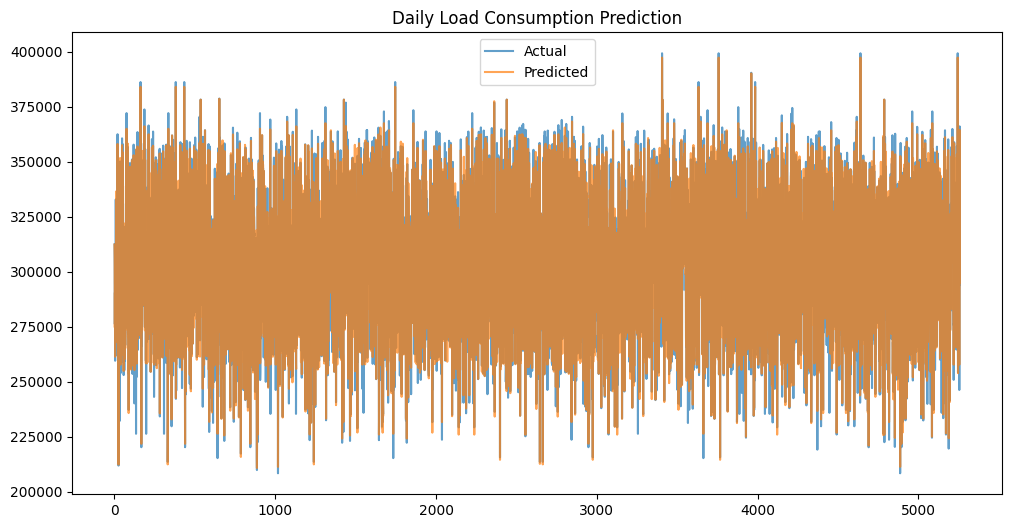

In [53]:
# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_daily.values, label="Actual", alpha=0.7)
plt.plot(y_pred_daily, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction")
plt.show()
